In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 80

ng =7

ng_refs = (/ 7 /) 

nref =1

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =294

vstar = 540

data w_diffuse
     &     /1.8 , 1.8 , 1.8 , 1.8,
     &     1.8 , 1.8 , 1.8/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.5,
     &     0.5 , 0.5 , 0.5/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

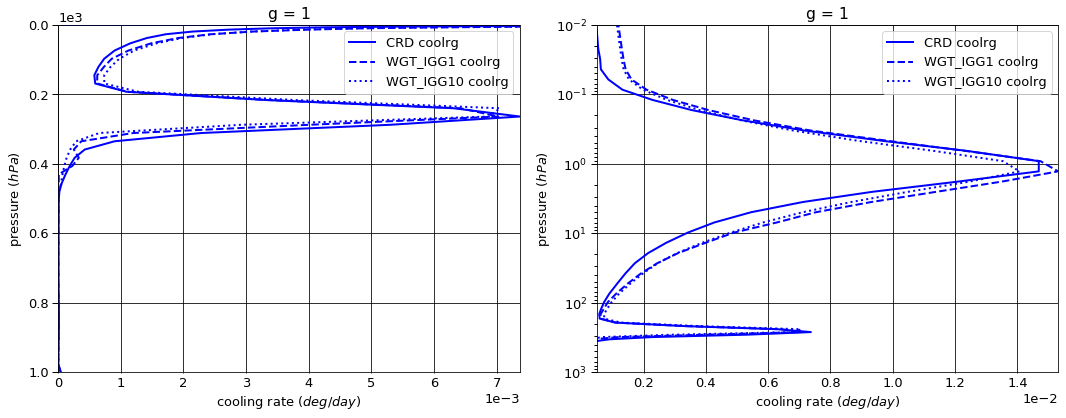

# Figure: cooling rate g-group 2

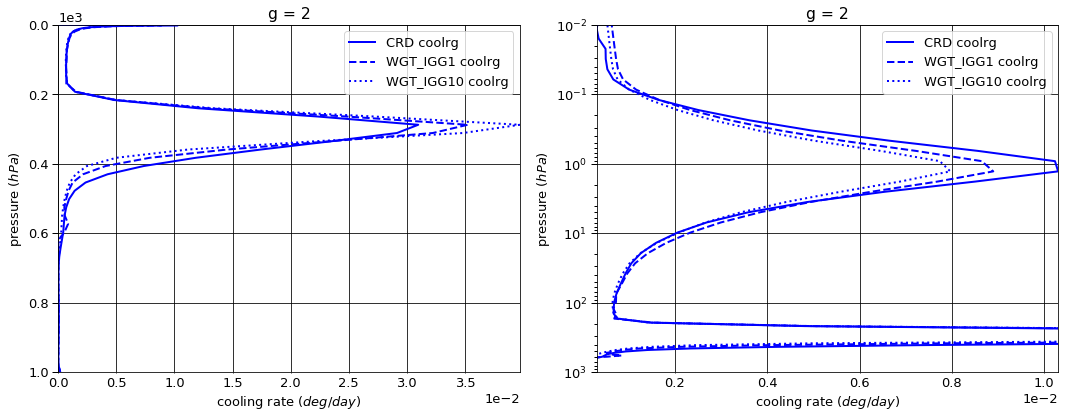

# Figure: cooling rate g-group 3

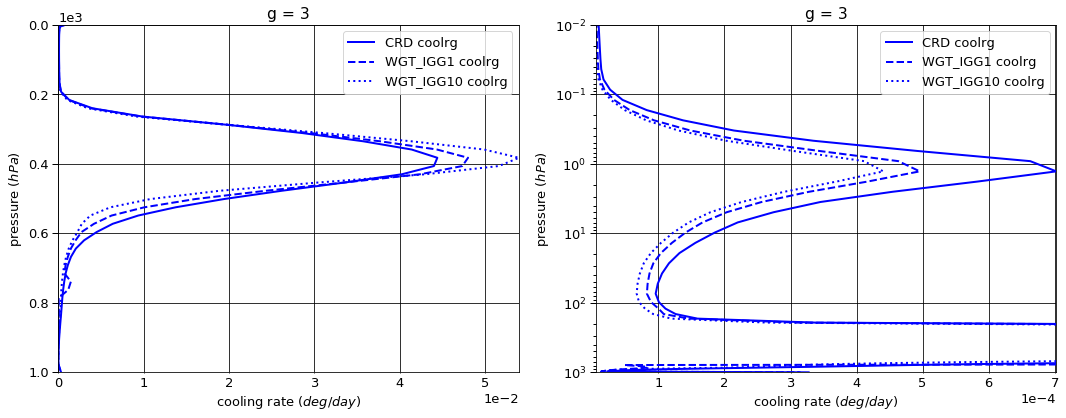

# Figure: cooling rate g-group 4

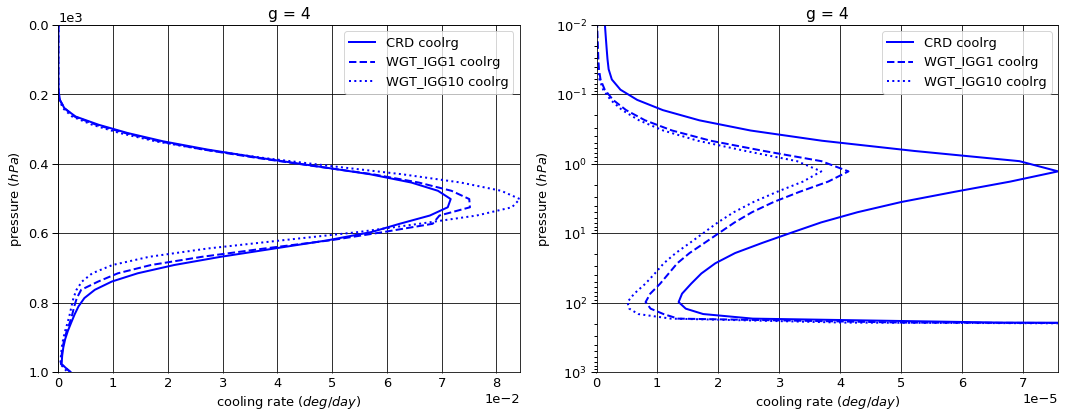

# Figure: cooling rate g-group 5

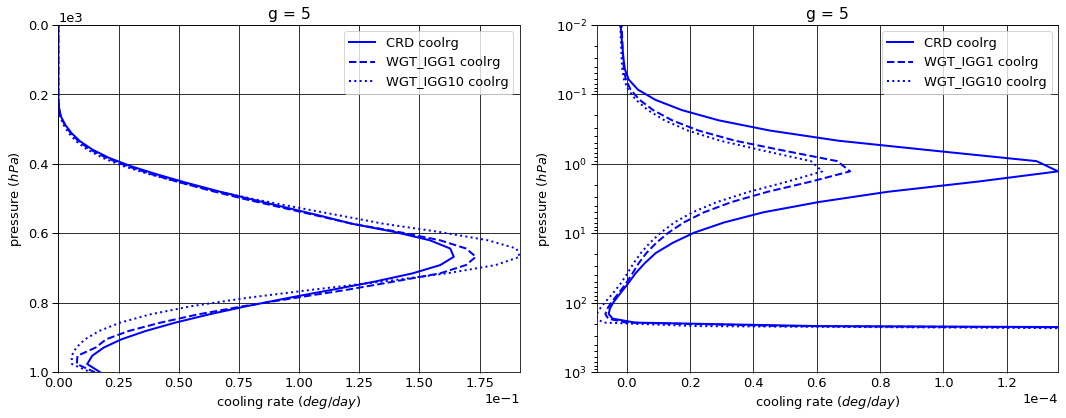

# Figure: cooling rate g-group 6

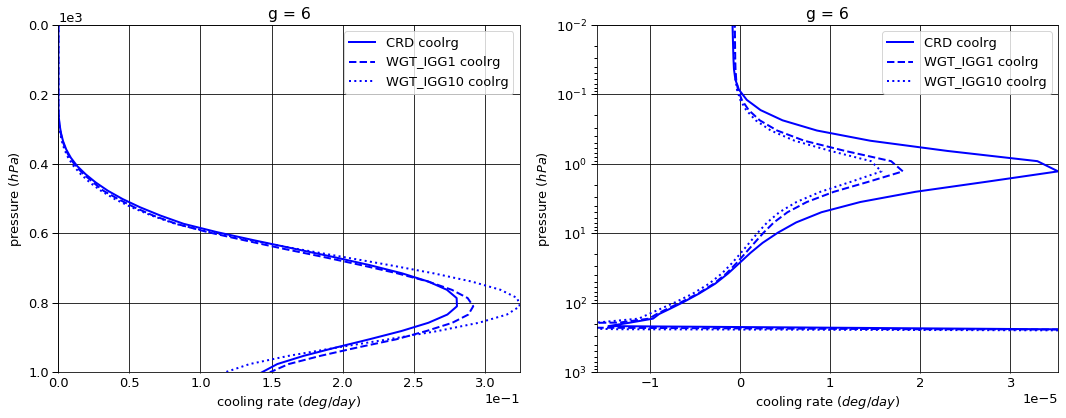

# Figure: cooling rate g-group 7

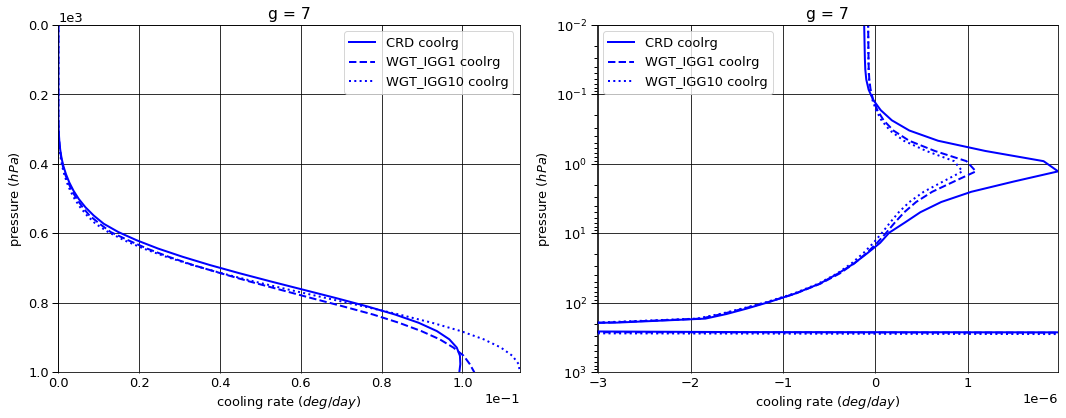

# Figure: cooling rate g-group total

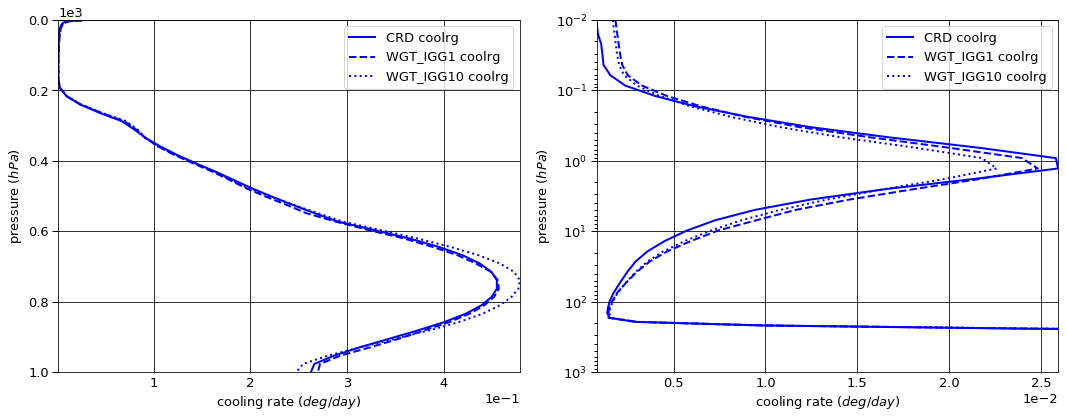

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.105958   0.000000  -0.105958
  1013.0   76     -0.244822   0.244711  -0.000111
2 0.0      1      -0.509708   0.000000  -0.509708
  1013.0   76     -1.035224   1.034753  -0.000471
3 0.0      1      -1.115506   0.000000  -1.115506
  1013.0   76     -1.920892   1.919995  -0.000897
4 0.0      1      -2.448116   0.000000  -2.448116
  1013.0   76     -3.608134   3.602368  -0.005766
5 0.0      1      -6.341205   0.000000  -6.341205
  1013.0   76     -8.145791   8.080567  -0.065224
6 0.0      1     -13.122344   0.000000 -13.122344
  1013.0   76    -15.079580  13.781216  -1.298364
7 0.0      1      -5.813407   0.000000  -5.813407
  1013.0   76     -6.200966   3.859425  -2.341541


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.103896   0.000000  -0.103896
  1013.0   76     -0.244822   0.244711  -0.000111
2 0.0      1      -0.499922   0.000000  -0.499922
  1013.0   76     -1.035224   1.034753  -0.000471
3 0.0      1      -1.104478   0.000000  -1.104478
  1013.0   76     -1.920892   1.920018  -0.000874
4 0.0      1      -2.440295   0.000000  -2.440295
  1013.0   76     -3.608134   3.602116  -0.006018
5 0.0      1      -6.333761   0.000000  -6.333761
  1013.0   76     -8.145791   8.094272  -0.051518
6 0.0      1     -13.153781   0.000000 -13.153781
  1013.0   76    -15.079580  13.938087  -1.141493
7 0.0      1      -5.842063   0.000000  -5.842063
  1013.0   76     -6.200966   3.670358  -2.530608


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.102408   0.000000  -0.102408
  1013.0   76     -0.244822   0.244711  -0.000111
2 0.0      1      -0.494873   0.000000  -0.494873
  1013.0   76     -1.035224   1.034753  -0.000471
3 0.0      1      -1.093017   0.000000  -1.093017
  1013.0   76     -1.920892   1.920018  -0.000874
4 0.0      1      -2.416094   0.000000  -2.416094
  1013.0   76     -3.608134   3.603773  -0.004361
5 0.0      1      -6.280169   0.000000  -6.280169
  1013.0   76     -8.145791   8.104750  -0.041041
6 0.0      1     -13.074320   0.000000 -13.074320
  1013.0   76    -15.079580  14.418578  -0.661002
7 0.0      1      -5.835332   0.000000  -5.835332
  1013.0   76     -6.200966   3.922956  -2.278010


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      2.061890e-03  0.000000  2.061890e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1      9.786490e-03  0.000000  9.786490e-03
  1013.0   76     0.000000e+00  0.000000  5.421011e-20
3 0.0      1      1.102750e-02  0.000000  1.102750e-02
  1013.0   76    -2.220446e-16  0.000023  2.332477e-05
4 0.0      1      7.820900e-03  0.000000  7.820900e-03
  1013.0   76     0.000000e+00 -0.000252 -2.521037e-04
5 0.0      1      7.444600e-03  0.000000  7.444600e-03
  1013.0   76     0.000000e+00  0.013705  1.370533e-02
6 0.0      1     -3.143700e-02  0.000000 -3.143700e-02
  1013.0   76     0.000000e+00  0.156871  1.568710e-01
7 0.0      1     -2.865600e-02  0.000000 -2.865600e-02
  1013.0   76     0.000000e+00 -0.189067 -1.890671e-01


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      3.549550e-03  0.000000  3.549550e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1      1.483530e-02  0.000000  1.483530e-02
  1013.0   76     0.000000e+00  0.000000  5.421011e-20
3 0.0      1      2.248840e-02  0.000000  2.248840e-02
  1013.0   76    -2.220446e-16  0.000023  2.332477e-05
4 0.0      1      3.202190e-02  0.000000  3.202190e-02
  1013.0   76     0.000000e+00  0.001405  1.404745e-03
5 0.0      1      6.103650e-02  0.000000  6.103650e-02
  1013.0   76     0.000000e+00  0.024183  2.418328e-02
6 0.0      1      4.802400e-02  0.000000  4.802400e-02
  1013.0   76     0.000000e+00  0.637362  6.373626e-01
7 0.0      1     -2.192480e-02  0.000000 -2.192480e-02
  1013.0   76     0.000000e+00  0.063531  6.353110e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      6.843116e-05
  1001.112500 75     4.001960e-05
2 0.000312    1      1.360172e-04
  1001.112500 75     1.698710e-04
3 0.000312    1      4.593553e-06
  1001.112500 75     3.274128e-04
4 0.000312    1      6.414094e-07
  1001.112500 75     2.227960e-03
5 0.000312    1     -3.749329e-06
  1001.112500 75     1.741432e-02
6 0.000312    1     -1.010486e-06
  1001.112500 75     1.431960e-01
7 0.000312    1     -1.366287e-07
  1001.112500 75     9.922235e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      8.550057e-04
  1001.112500 75     4.001960e-05
2 0.000312    1      4.364303e-04
  1001.112500 75     1.698710e-04
3 0.000312    1      3.007556e-06
  1001.112500 75     3.152178e-04
4 0.000312    1     -2.116917e-07
  1001.112500 75     2.324962e-03
5 0.000312    1     -2.518242e-06
  1001.112500 75     1.521269e-02
6 0.000312    1     -6.613129e-07
  1001.112500 75     1.487867e-01
7 0.000312    1     -8.657877e-08
  1001.112500 75     1.029345e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      8.345052e-04
  1001.112500 75     4.001960e-05
2 0.000312    1      3.650083e-04
  1001.112500 75     1.698710e-04
3 0.000312    1      2.020654e-06
  1001.112500 75     3.152178e-04
4 0.000312    1     -2.698892e-07
  1001.112500 75     1.713281e-03
5 0.000312    1     -2.789770e-06
  1001.112500 75     1.341314e-02
6 0.000312    1     -6.818228e-07
  1001.112500 75     1.173288e-01
7 0.000312    1     -8.561812e-08
  1001.112500 75     1.141941e-01


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      7.865745e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      3.004130e-04
  1001.112500 75    -2.710505e-20
3 0.000312    1     -1.585998e-06
  1001.112500 75    -1.219496e-05
4 0.000312    1     -8.531011e-07
  1001.112500 75     9.700180e-05
5 0.000312    1      1.231088e-06
  1001.112500 75    -2.201632e-03
6 0.000312    1      3.491731e-07
  1001.112500 75     5.590750e-03
7 0.000312    1      5.004998e-08
  1001.112500 75     3.712166e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      7.660741e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      2.289910e-04
  1001.112500 75    -2.710505e-20
3 0.000312    1     -2.572900e-06
  1001.112500 75    -1.219496e-05
4 0.000312    1     -9.112986e-07
  1001.112500 75    -5.146797e-04
5 0.000312    1      9.595594e-07
  1001.112500 75    -4.001175e-03
6 0.000312    1      3.286631e-07
  1001.112500 75    -2.586724e-02
7 0.000312    1      5.101063e-08
  1001.112500 75     1.497172e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.456244,0.000000,-29.456244
1013.0,76,-36.235408,32.523034,-3.712375



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.478196,0.000000,-29.478196
1013.0,76,-36.235408,32.504314,-3.731094



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.296213,0.000000,-29.296213
1013.0,76,-36.235408,33.249538,-2.985870



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.195162e-02,0.00000,-0.021952
1013.0,76,-7.105427e-15,-0.01872,-0.018720



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.600309e-01,0.000000,0.160031
1013.0,76,-7.105427e-15,0.726504,0.726505


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000205
1001.112500,75,0.262598



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.001291
1001.112500,75,0.269784



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.001198
1001.112500,75,0.247174



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001086
1001.112500,75,0.007186



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000993
1001.112500,75,-0.015424


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.006750,0.006798
2,0.028563,0.028687
3,0.053000,0.053233
4,0.099562,0.100153
5,0.224750,0.225604
6,0.416125,0.416491
7,0.171250,0.169035


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.643251e-21
2,1.773812e-21
3,4.116584e-22
4,9.553585e-23
5,2.217154e-23
6,5.145472e-24
7,1.194138e-24


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.643251e-21,NaN,0.006750,0.006798,0.006750,0.006798,600.0
2,1.773812e-21,0.232076,0.028563,0.028687,0.035313,0.035485,600.0
3,4.116584e-22,0.232076,0.053000,0.053233,0.088313,0.088718,600.0
4,9.553585e-23,0.232076,0.099562,0.100153,0.187875,0.188871,600.0
5,2.217154e-23,0.232076,0.224750,0.225604,0.412625,0.414475,600.0
6,5.145472e-24,0.232076,0.416125,0.416491,0.828750,0.830965,600.0
7,1.194138e-24,0.232076,0.171250,0.169035,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.110165e-20  5.418171e-22  20.489664  6.756430e-07
      2 0.000312     1.663596e-21  3.544784e-23  46.930804  1.000772e-07
      3 0.000312     1.292425e-23  1.316204e-24   9.819339  8.040779e-10
      4 0.000312     1.423965e-24  1.964193e-25   7.249615  6.899687e-11
      5 0.000312     2.093728e-24  1.233517e-25  16.973649  9.440454e-11
      6 0.000312     1.587512e-25  1.643775e-26   9.657720  7.459648e-12
      7 0.000312     3.481954e-26  4.174018e-27   8.341972  1.660368e-12
2     1 0.000750     1.115929e-20  5.424734e-22  20.571118  2.735307e-07
      2 0.000750     1.671709e-21  3.547986e-23  47.117123  4.050491e-08
      3 0.000750     1.307481e-23  1.320827e-24   9.898958  3.275344e-10
      4 0.000750     1.435581e-24  1.971851e-25   7.280372  2.800339e-11
      5 0.000750     2.104271e-24  1.237005e-25  17.011020  3.821169e-11
      6 0.000750     1.599841e-25  1.652078e-26   9.683810  3.027215e-12
      7 0.000750     3.496547e-26  4.191380e-27   8.342234  6.715748e-13
3     1 0.001052     1.128207e-20  5.436181e-22  20.753671  3.877466e-07
      2 0.001052     1.689072e-21  3.552168e-23  47.550457  5.738878e-08
      3 0.001052     1.339669e-23  1.328344e-24  10.085253  4.702767e-10
      4 0.001052     1.460113e-24  1.986342e-25   7.350764  3.989645e-11
      5 0.001052     2.126840e-24  1.244000e-25  17.096791  5.414719e-11
      6 0.001052     1.626242e-25  1.668593e-26   9.746189  4.312797e-12
      7 0.001052     3.527279e-26  4.226018e-27   8.346577  9.500316e-13
4     1 0.001476     1.141314e-20  5.448700e-22  20.946529  5.501833e-07
      2 0.001476     1.707594e-21  3.557024e-23  48.006262  8.138623e-08
      3 0.001476     1.374539e-23  1.336677e-24  10.283255  6.763889e-10
      4 0.001476     1.486509e-24  2.002087e-25   7.424799  5.691422e-11
      5 0.001476     2.150994e-24  1.251549e-25  17.186659  7.680315e-11
      6 0.001476     1.654691e-25  1.686305e-26   9.812526  6.152358e-12
      7 0.001476     3.560253e-26  4.263974e-27   8.349613  1.345199e-12
5     1 0.002070     1.154546e-20  5.461868e-22  21.138299  7.804847e-07
      2 0.002070     1.726274e-21  3.562606e-23  48.455392  1.153906e-07
      3 0.002070     1.410304e-23  1.345649e-24  10.480475  9.726455e-10
      4 0.002070     1.513412e-24  2.018462e-25   7.497846  8.117784e-11
      5 0.002070     2.175442e-24  1.259304e-25  17.274955  1.089168e-10
      6 0.002070     1.683699e-25  1.704389e-26   9.878608  8.775063e-12
      7 0.002070     3.593772e-26  4.303608e-27   8.350602  1.904497e-12
6     1 0.002904     1.167895e-20  5.475987e-22  21.327581  1.107279e-06
      2 0.002904     1.745092e-21  3.569220e-23  48.892804  1.636143e-07
      3 0.002904     1.446976e-23  1.355519e-24  10.674700  1.398844e-09
      4 0.002904     1.540845e-24  2.035676e-25   7.569202  1.158067e-10
      5 0.002904     2.200165e-24  1.267317e-25  17.360811  1.544762e-10
      6 0.002904     1.713261e-25  1.722966e-26   9.943672  1.251770e-11
      7 0.002904     3.627870e-26  4.345242e-27   8.349062  2.696911e-12
7     1 0.004074     1.181367e-20  5.491495e-22  21.512659  1.570911e-06
      2 0.004074     1.764040e-21  3.577302e-23  49.312016  2.319886e-07
      3 0.004074     1.484617e-23  1.366662e-24  10.863087  2.011959e-09
      4 0.004074     1.568876e-24  2.054044e-25   7.637985  1.652321e-10
      5 0.004074     2.225164e-24  1.275668e-25  17.443124  2.191010e-10
      6 0.004074     1.743402e-25  1.742231e-26  10.006719  1.785812e-11
      7 0.004074     3.662636e-26  4.389364e-27   8.344342  3.819640e-12
8     1 0.005714     1.194965e-20  5.509005e-22  21.691123  2.228492e-06
      2 0.005714     1.783109e-21  3.587462e-23  49.703925  3.289012e-07
      3 0.005714     1.523305e-23  1.379596e-24  11.041676  2.893899e-09
      4 0.005714     1.597599e-24  2.074009e-25   7.702949  2.357805e-10
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
